In [ ]:
# Author: Yuki Rivera
# This notebook contains code to evaluate the bart-base model fine-tuned with our anime project dataset

### Installs required libraries

In [ ]:
!pip install umap-learn

In [ ]:
!apt-get update
!apt-get install unzip

In [ ]:
pip install torch transformers sentence-transformers scikit-learn matplotlib pandas numpy


### Import necessary libraries

In [4]:
from torch.nn import CrossEntropyLoss
from transformers import BartForConditionalGeneration, BartTokenizer
from sentence_transformers import SentenceTransformer, util
import torch, json
import pandas as pd
import os
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
import numpy as np

### Unzip the final model

In [ ]:
!mkdir -p ./final_model_extracted

!unzip ./final_model.zip -d ./final_model_extracted

Archive:  ./final_model.zip
  inflating: ./final_model_extracted/training_args.bin  
  inflating: ./final_model_extracted/merges.txt  
  inflating: ./final_model_extracted/vocab.json  
  inflating: ./final_model_extracted/special_tokens_map.json  
  inflating: ./final_model_extracted/tokenizer_config.json  
  inflating: ./final_model_extracted/model.safetensors  
  inflating: ./final_model_extracted/generation_config.json  
  inflating: ./final_model_extracted/config.json  
  inflating: ./final_model_extracted/trainer_log_history.json  


### Loads the model and tokenizer

In [6]:
model_path = "/workspace/final_model_extracted/"

In [7]:
model = BartForConditionalGeneration.from_pretrained(model_path)
tokenizer = BartTokenizer.from_pretrained(model_path)

### Loads the testing dataset

In [ ]:
df = pd.read_csv("prompt_synopsis_test.csv")
testing_df = df.iloc[[20, 26, 64,84,88,98,106,111,127,164,190,199,225,231,242,244,259,298, 10597, 10609]]
testing_df = testing_df.reset_index(drop=True)

In [10]:
prompts = testing_df["prompt"].tolist()
references = testing_df["synopsis"].tolist()
tags_list = testing_df['tags_combined'].tolist()

In [11]:
dec_max_len = 150
enc_max_len = 64

In [ ]:
# Tokenizes inputs (prompts)
encodings = tokenizer(
    prompts,
    padding=True,
    truncation=True,
    max_length = enc_max_len,
    return_tensors="pt"
)

# Tokenizes outputs (references)
with tokenizer.as_target_tokenizer():
    target_encodings = tokenizer(
        references,
        padding=True,
        truncation=True,
        max_length = dec_max_len,
        return_tensors="pt"
    )

labels = target_encodings["input_ids"]
# Ensures the pad token will be ignored
labels[labels == tokenizer.pad_token_id] = -100

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


### Calculates test perplexity and saves the value to a text file

In [13]:
# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_ids = encodings["input_ids"].to(device)
attention_mask = encodings["attention_mask"].to(device)
labels = labels.to(device)
model = model.to(device)
model.eval()

# Calculate loss and perplexity
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    perplexity = torch.exp(loss).item()

print(f"BART Test Perplexity: {perplexity:.2f}")

BART Test Perplexity: 47.53


In [ ]:
with open('avg_perplexity_bart.txt', 'w') as f:
    f.write(str(perplexity))

### Generate Text and Calculate Cosine Similarity

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Loads SentenceTransformer model for embeddings
embedder = SentenceTransformer("all-MiniLM-L6-v2")


results = []

for i in range(len(prompts)):
    prompt = prompts[i]
    true_synopsis = references[i]  
    tags = tags_list[i]

    # Generates text 
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(device)

    # disables gradient tracking to save memory and speed up inference
    with torch.no_grad():
        output_ids = model.generate(
            inputs["input_ids"], 
            max_new_tokens=50, 
            do_sample=True,
            top_k=30,
            top_p=0.85,
            temperature=0.7,
            repetition_penalty=1.3,
            early_stopping=True,
        )

    # Decodes and truncate at the last complete sentence
    generated_raw = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    # Finds last sentence-ending period
    last_period_index = generated_raw.rfind(".")
    
    if last_period_index != -1:
        generated = generated_raw[:last_period_index + 1]
    else:
        generated = generated_raw  
    
    # Embeds tags and generated text
    emb_tags = embedder.encode(tags, convert_to_tensor=True, device=device)
    emb_generated = embedder.encode(generated, convert_to_tensor=True, device=device)

    similarity = util.cos_sim(emb_tags, emb_generated).item()

    results.append({
        "tags_combined": tags,
        "prompt": prompt,
        "generated": generated,
        "true_synopsis": true_synopsis,
        "cosine_similarity": similarity
    })

    if i < 20:
        print(f"Prompt {i+1}: {prompt}")
        print(f"Generated: {generated}")
        print(f"True:      {true_synopsis}")
        print(f"Cosine Similarity: {similarity:.3f}")
        print("—" * 50)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Prompt 1: Write an anime synopsis that matches 'Adventure, Comedy and Fantasy'.
Generated: the story takes place in a world where humans and demons live together. this world is ruled by the king, who is the only one who knows the true nature of the human race.
True:      on one noteworthy day in the adventurer's guild, kazuma satou encounters someone unexpecteda fan of his named ran. surprised that he even has a fan, kazuma attempts to play it cool to impress her. unfortunately for him, the guild's receptionist arrives with a request to defeat a giant golem guarding some ancient ruins, and kazuma accepts only to keep ran's admiration. upon kazuma and his party's successful return from the ruins, kazuma continues to shamelessly brag to ran. capitalizing on his desperation, the receptionist approaches him with another quest that requires him to return to the same ruins. hoping to find valuable treasures, kazuma once again convinces his party to join himbut this time, he may be biting off

### Avg Cosine Similarity

In [ ]:
# Extracts all cosine similarities
cosine_scores = [row["cosine_similarity"] for row in results]

# Computes average
avg_similarity = np.mean(cosine_scores)
print(f"Average Cosine Similarity: {avg_similarity:.3f}")

# saves to a text file
with open('avg_sim_bart.txt', 'w') as f:
    f.write(str(avg_similarity))

Average Cosine Similarity: 0.284


### Saves all results to a csv file

In [ ]:
df = pd.DataFrame(results)

df.to_csv("bart_generation_results.csv", index=False, encoding="utf-8")

### Scatter Plot of Embeddings

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


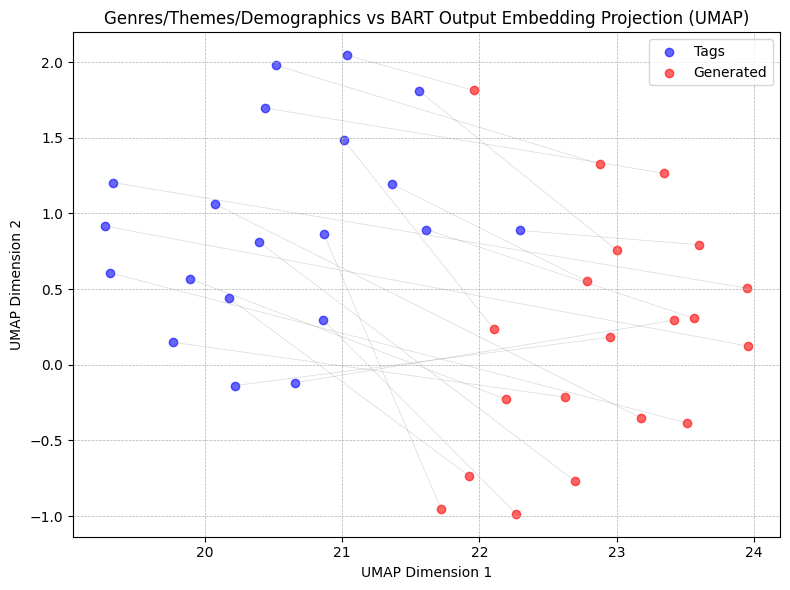

In [ ]:
# converts each tags and generated output into a high-dim vector
tags_embeddings = embedder.encode([row["tags_combined"] for row in results])
gen_embeddings = embedder.encode([row["generated"] for row in results])

# combines both embeddings into a single array
all_embeddings = np.vstack((tags_embeddings, gen_embeddings))
labels = ['Tags'] * len(tags_embeddings) + ['Generated'] * len(gen_embeddings)

# reduces the dimension for visualization
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
reduced = reducer.fit_transform(all_embeddings)

# splits embeddings into the tags and the output
reduced_tags = reduced[:len(tags_embeddings)]
reduced_gen = reduced[len(tags_embeddings):]

# Plot a scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(reduced_tags[:, 0], reduced_tags[:, 1], c='blue', alpha=0.6, label='Tags')
plt.scatter(reduced_gen[:, 0], reduced_gen[:, 1], c='red', alpha=0.6, label='Generated')

# Draw lines between corresponding tag and generated embeddings
for i in range(len(reduced_tags)):
    x_values = [reduced_tags[i, 0], reduced_gen[i, 0]]
    y_values = [reduced_tags[i, 1], reduced_gen[i, 1]]
    plt.plot(x_values, y_values, 'gray', alpha=0.3, linewidth=0.5)

plt.title("Genres/Themes/Demographics vs BART Output Embedding Projection (UMAP)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('scatter_plot_bart.png', dpi=300, bbox_inches='tight')
plt.show()
